In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time

import plotly.io as pio
pio.renderers.default = 'notebook'

## Table of Contents

# Load Data
- Load data from DeFiLlama
- Load data from disk

# Fit Slippage Model
- Fit kink models
- Prepare historical slippage

# Choose a Strategy
- Set up Strategy triggers
- Choose from pre-coded strategies:
    - Brute Force Optimization
    - Quadratic Optimization
    - Market Portfolio 

# Run Backtest
- Run single strategy runs

# Analyze Backtests
- Analyze results with pre-built plotting
- Write your own analysis

# Run Backtests in Parallel
- Run one backtest per CPU if required


# Loading Data

In [ ]:
from dope.fetcher.llama import Llama
from dope.market_impact.linear import LinearMktImpactModel
from dope.market_impact.neighborhood import NeighborhoodMktImpactModel

## Load Data From DefiLlama

In [11]:
pool_urls = {}
pool_urls["USDT"] = """
# USDT
https://defillama.com/yields/pool/f981a304-bb6c-45b8-b0c5-fd2f515ad23a
https://defillama.com/yields/pool/4e8cc592-c8d5-4824-8155-128ba521e903
https://defillama.com/yields/pool/60d657c9-5f63-4771-a85b-2cf8d507ec00
https://defillama.com/yields/pool/c037a916-a462-4c65-b217-100db0fdc0e0
https://defillama.com/yields/pool/57647093-2868-4e65-97ab-9cae8ec74e7d
https://defillama.com/yields/pool/043a8330-bc29-4164-aa1c-28de7bf87755
https://defillama.com/yields/pool/4cecbdfa-7189-4801-88ef-cdfee4b23298
https://defillama.com/yields/pool/a3a5cf89-9a9e-4db7-8f6d-1af3d5714d79
https://defillama.com/yields/pool/4ce0c458-2171-463b-92ce-458afe367a4e
# https://defillama.com/yields/pool/2bad58b8-13f6-41c6-9245-a9dc1ea85be9
https://defillama.com/yields/pool/edaefc40-d818-48bd-a87a-d9c87598c1bc
https://defillama.com/yields/pool/1350803f-262c-4c7e-b134-d2f693c7a7c8
# https://defillama.com/yields/pool/6bb4b00c-188f-41a0-8b2d-96ce2a531622
https://defillama.com/yields/pool/c88d4008-f567-44e6-8ac8-a56d4f765a62
# https://defillama.com/yields/pool/e43ddfa2-5e6b-40b2-ae74-d01e1a1c10b8
# https://defillama.com/yields/pool/f4bb0e79-07b9-434a-9340-a5da72e7ff9e
https://defillama.com/yields/pool/612af285-321a-4295-8362-59a6113da145
"""
def url_raw_to_pool_id(url_raw):
  return [url.split("/")[-1] for url in  url_raw.split("\n")[1:-1] if "#" not in url]

pool_ids = {t:url_raw_to_pool_id(pool_ids) for t, pool_ids in pool_urls.items()}

In [12]:
from dope.backengine.maestro import BackEngineMaestro
maestro = BackEngineMaestro()

In [101]:
data, borrow_lend_data = maestro.load_defilama_with_token_pool_id(pool_ids)

USDT
Ethereum:aave-v3:USDT f981a304-bb6c-45b8-b0c5-fd2f515ad23a 420 420
Ethereum:fluid:USDT 4e8cc592-c8d5-4824-8155-128ba521e903 56 56
Ethereum:compound-v2:USDT 57647093-2868-4e65-97ab-9cae8ec74e7d 420 420
Ethereum:morpho-blue(86%):WBTC-USDT c037a916-a462-4c65-b217-100db0fdc0e0 160 160
Ethereum:aave-v2:USDT 60d657c9-5f63-4771-a85b-2cf8d507ec00 418 418
Ethereum:morpho-blue(100%):BBUSDT 043a8330-bc29-4164-aa1c-28de7bf87755 58 58
Ethereum:morpho-blue(86%):WSTETH-USDT 4ce0c458-2171-463b-92ce-458afe367a4e 160 160
Ethereum:morpho-blue(100%):GTUSDT 4cecbdfa-7189-4801-88ef-cdfee4b23298 58 58
Ethereum:morpho-blue(91.5%):SUSDE-USDT a3a5cf89-9a9e-4db7-8f6d-1af3d5714d79 123 123
Ethereum:morpho-blue(100%):RE7USDT 1350803f-262c-4c7e-b134-d2f693c7a7c8 58 58
Ethereum:morpho-blue(91.5%):USDE-USDT c88d4008-f567-44e6-8ac8-a56d4f765a62 119 119
Ethereum:gearbox:USDT edaefc40-d818-48bd-a87a-d9c87598c1bc 112 112


In [102]:
maestro.set_data(borrow_lend_data)

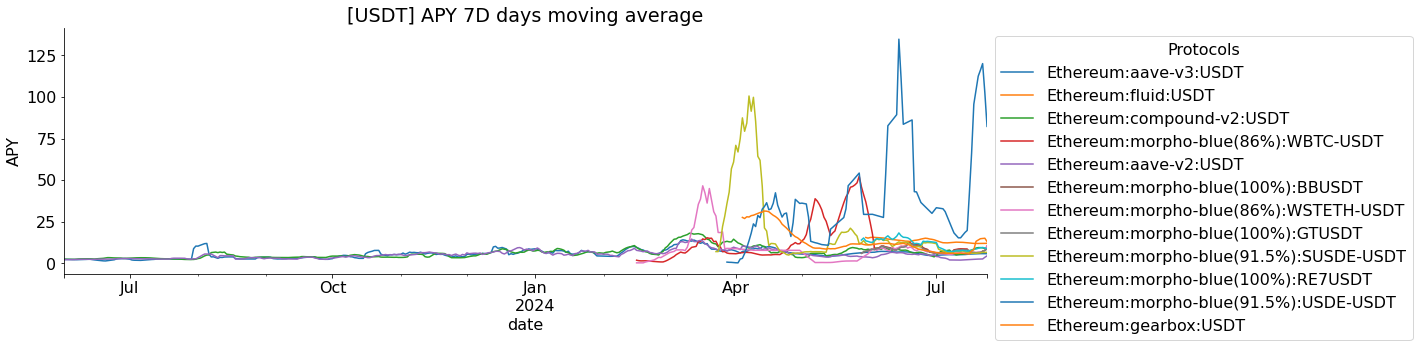

In [103]:
maestro.plot_rates_ts(agg_str="7D")

## Load data from Disk

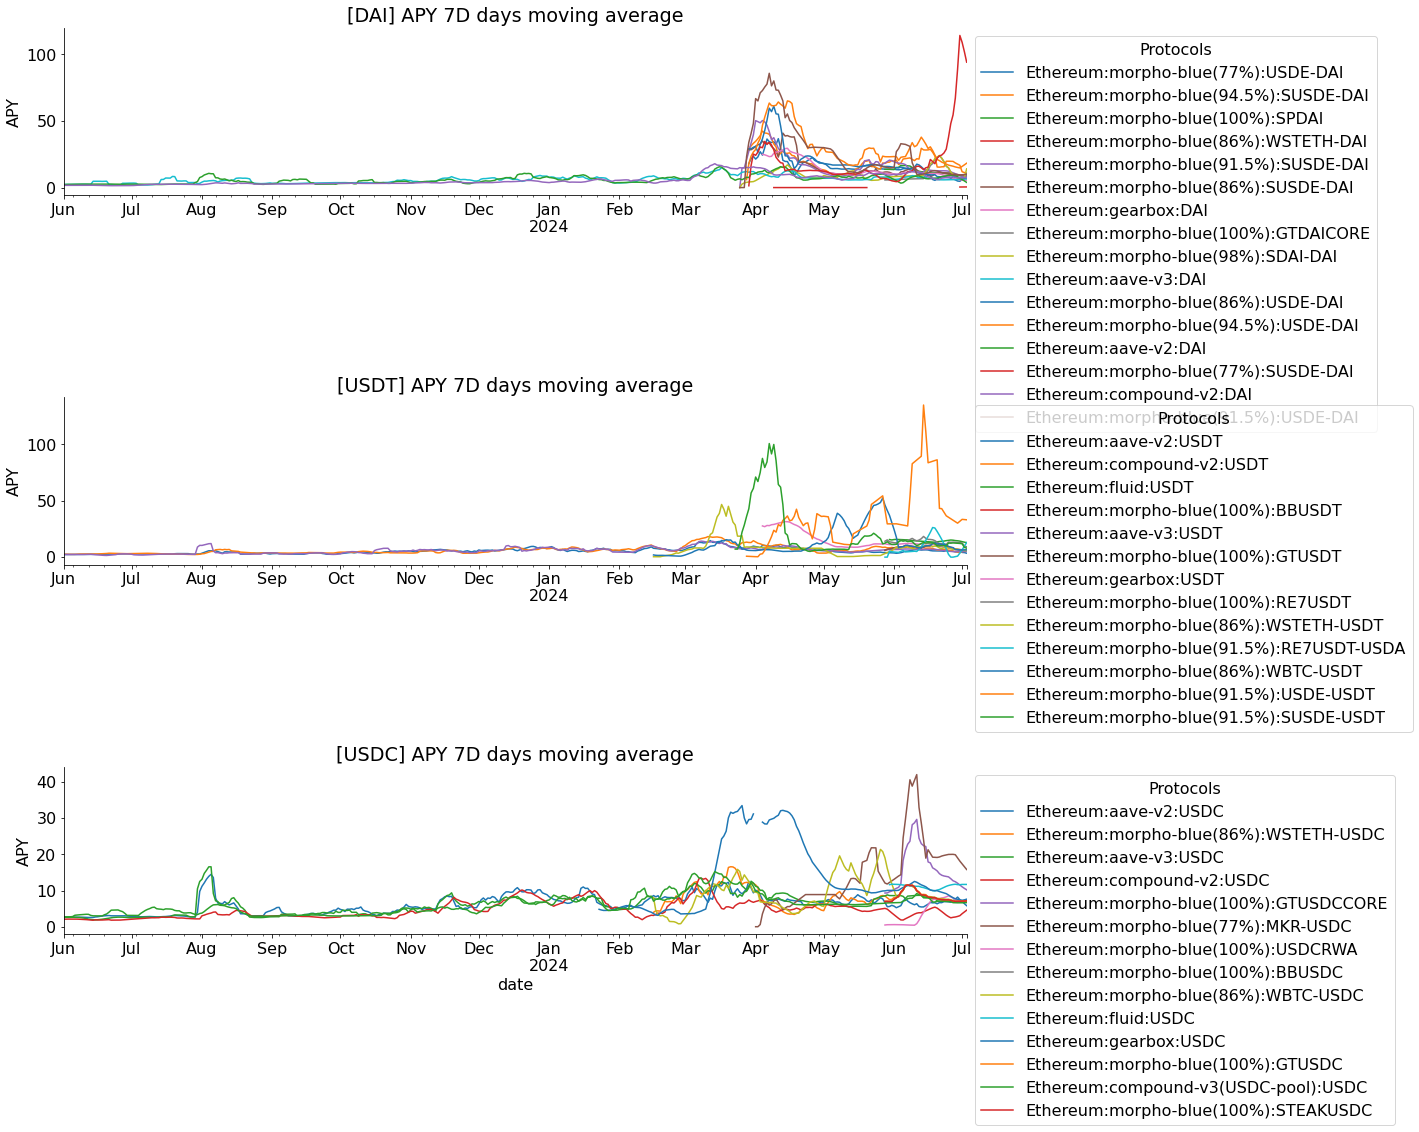

In [67]:
from dope.backengine.maestro import BacktestData 

maestro = BackEngineMaestro()
maestro.set_data(BacktestData.load("arb-data-03-07-2024"))

maestro.plot_rates_ts(agg_str="7D")

# Slippage Models

## Kink models

In [99]:
# Load data market model example
_run_data = BacktestData.load("arb-data-03-07-2024")
_run_data = BacktestData({
  "USDT":{
    "Ethereum:morpho-blue(86%):WSTETH-USDT":_run_data["USDT"]["Ethereum:morpho-blue(86%):WSTETH-USDT"],
    "Ethereum:aave-v3:DAI": _run_data["DAI"]["Ethereum:aave-v3:DAI"]
  }
})

Ethereum:morpho-blue(86%):WSTETH-USDT 139


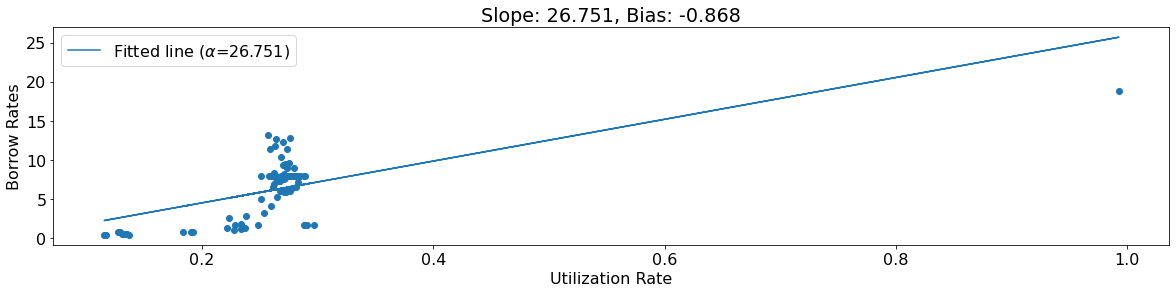

Ethereum:aave-v3:DAI 399


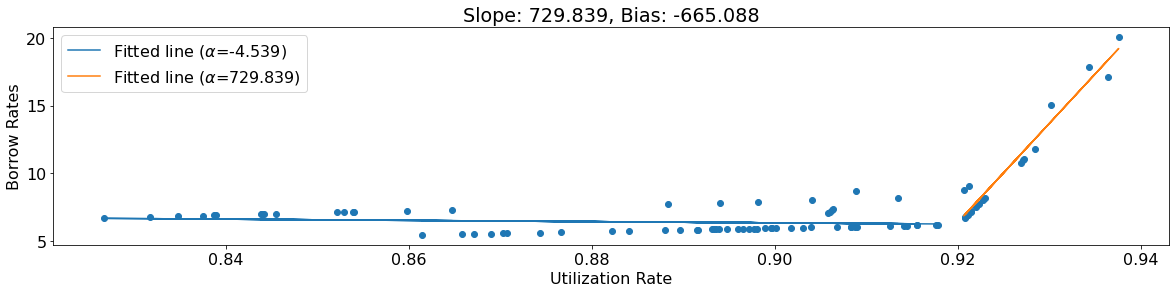

In [100]:
maestro.set_data(BacktestData.load("arb-data-03-07-2024"))
from collections import defaultdict
kinks = defaultdict(lambda: None)
kinks["Ethereum:aave-v3:DAI"] = [0.92]

maestro = BackEngineMaestro()
maestro.set_data(_run_data)
_ = maestro.estimate_mkt_impact_model(should_plot=False, kinks=kinks)

## Historical Slippage Model

In [25]:
mkt_model = NeighborhoodMktImpactModel()

2023-09-09 00:00:00


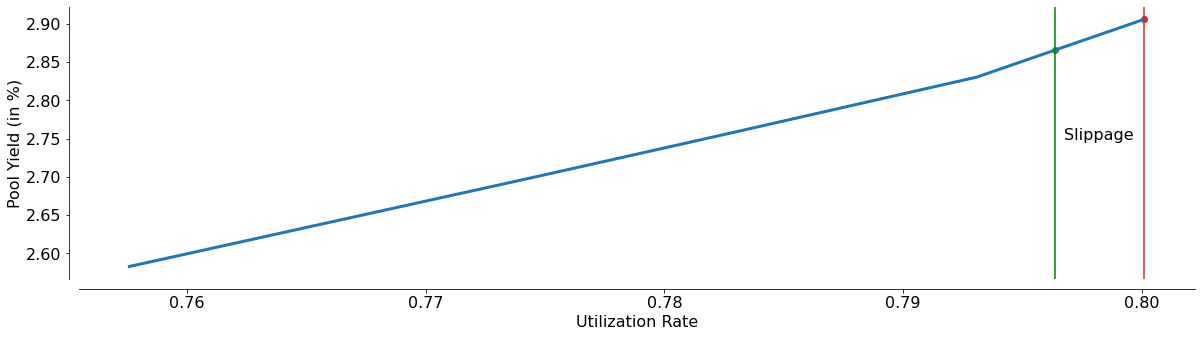

In [50]:
token = "USDT"
mkt = "Ethereum:aave-v3:USDT"
mkt_model.set_data_ref(borrow_lend_data[token][mkt])
date_now = borrow_lend_data[token][mkt].index[100]
print(date_now)
_ = mkt_model.impact(date_now,  1_000_000, is_borrow=False, should_plot=True)

2024-03-14 00:00:00


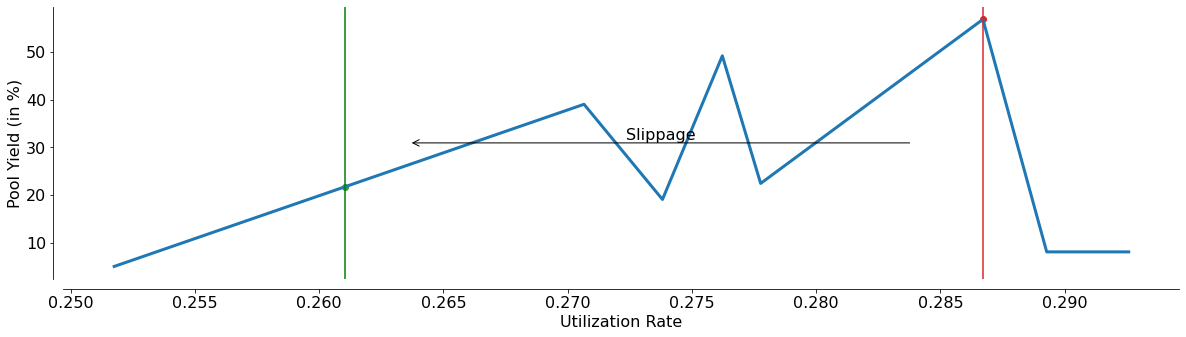

In [65]:
token = "USDT"
mkt = "Ethereum:morpho-blue(86%):WSTETH-USDT"
mkt_model.set_data_ref(borrow_lend_data[token][mkt])
date_now = borrow_lend_data[token][mkt].index[27]
print(date_now)
_ = mkt_model.impact(date_now, 200_000, is_borrow=False, should_plot=True)

## Video for Market Slippage
https://x.com/ipor_io/status/1811706124078395458

# Backtest

In [69]:
from dope.backengine.naive_arb import NaiveArbBacktest
from dope.backengine.agents.jackreaper import LenderJackReaper

In [70]:
from dope.backengine.arbengine import ArbBacktester
from dope.market_impact.linear import LinearMktImpactModel
from dope.backengine.agents.arb import ArbStrategy

from dope.backengine.agents.jackreaper import LenderJackReaper
from dope.backengine.agents.quadratic import LenderQuadratic

from dope.backengine.runsummary import BacktestSummary

In [71]:
summaries = {}

ws = {}
CAPITAL = 1_000_000
maestro = BackEngineMaestro()

In [72]:
enhanced_borrow_lend_data = {t:{} for t in borrow_lend_data.keys()}
for token in enhanced_borrow_lend_data.keys():
  for mkt in borrow_lend_data[token].keys():
    enhanced_borrow_lend_data[token][mkt] = borrow_lend_data[token][mkt].resample("1H").last().interpolate()

  from dope.backengine.maestro import BacktestData

enhanced_borrow_lend_data = BacktestData(enhanced_borrow_lend_data)

In [73]:
run_data = borrow_lend_data
#run_data = enhanced_borrow_lend_data

#run_data.add_cash_mkt()

In [75]:
from dope.backengine.agents.jackreaper import LenderJackReaper
from dope.market_impact.neighborhood import NeighborhoodMktImpactModel
from dope.market_impact.linear import LinearMktImpactModel

mkt_impact = {
  mkt: NeighborhoodMktImpactModel(past_window_days=7, future_window_days=0)
  for mkt in run_data.get_markets()
}
mkt_impact["cash"] = LinearMktImpactModel.zero_instance()

## Choose your strategy

In [85]:
# Daily triggers for benchmark
triggers = run_data.to_block(token).utilizationRate.resample("7D").last().index[1:]

strategy = LenderJackReaper(token=token, capital=CAPITAL, days_window=7, triggers=triggers)
strategy.verbose = False
arbt = ArbBacktester(strategy=strategy, borrow_lend_data=run_data, data=run_data, mkt_impact=mkt_impact)
summaries["loop:jackreaper"], _ = arbt()

Running Backtest for 420 | token:USDT


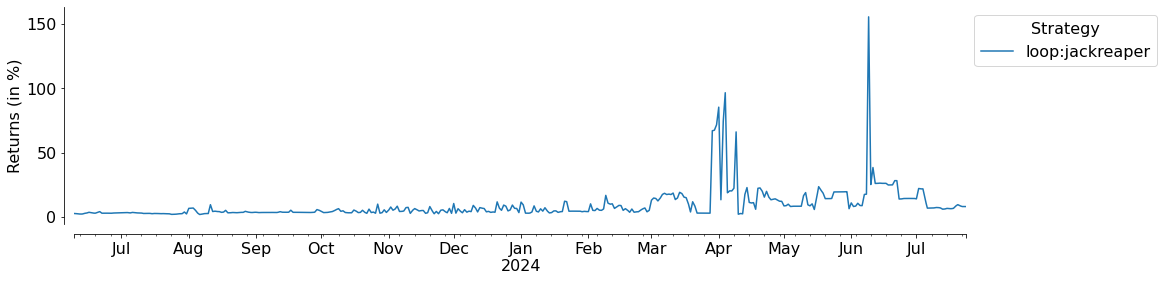

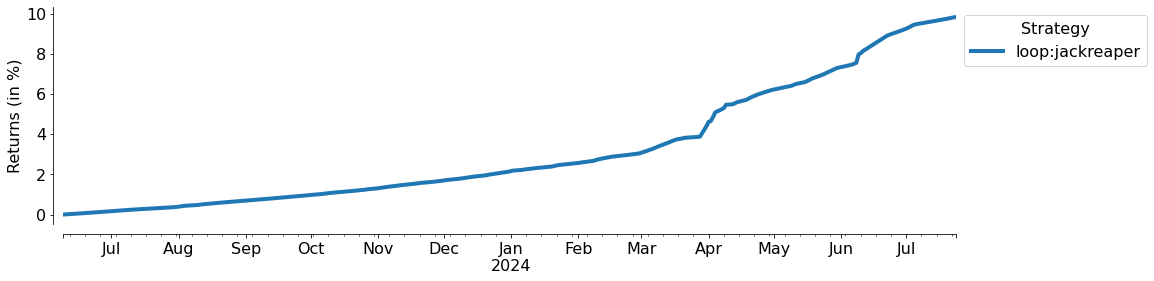

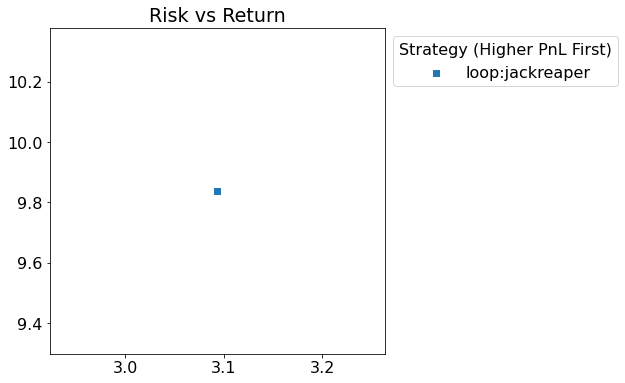

loop:jackreaper    9.838788
dtype: float64


In [78]:
summary = pd.concat(summaries).unstack(level=0)
from dope.backengine.runsummary import BacktestSummary
from dope.backengine.plotting.fofarticle import Plotter
plot = Plotter(summary)
plot.summary_view()

# Analysis

## Load Backtests from Disk

In [79]:
_summaries = {}

bts = {
  "mainchain-lend": "main-chain-daily-triggers-hourly-data",
  "mainPlus-arb": "optimization+stable-arb-many-protocols",
  "mainPlus-lend":"2024-06-03-main-chain-daily-triggers-daily-data-many-protocols",
}

for _run_tag, _run_name in bts.items():
  _run = BacktestSummary.load(_run_name)
  _summaries.update({f"{_run_tag}-{k}":_run.summary[k] for k in _run.summary.keys()})

summary = pd.concat(_summaries).unstack(level=0)

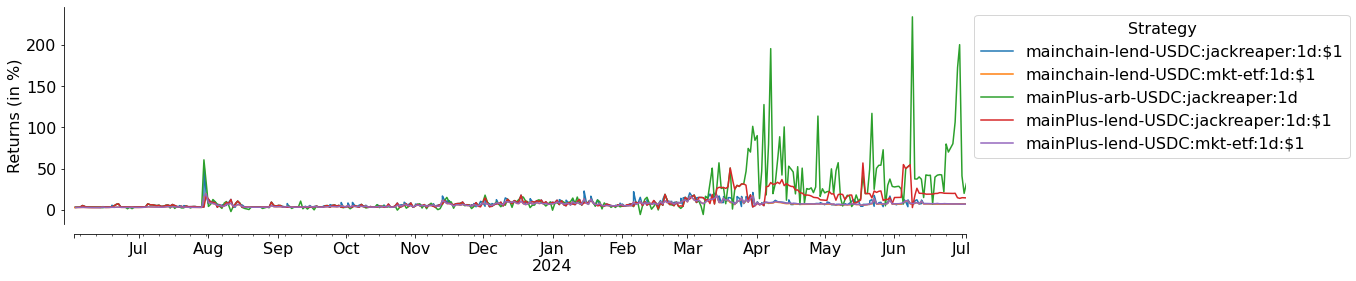

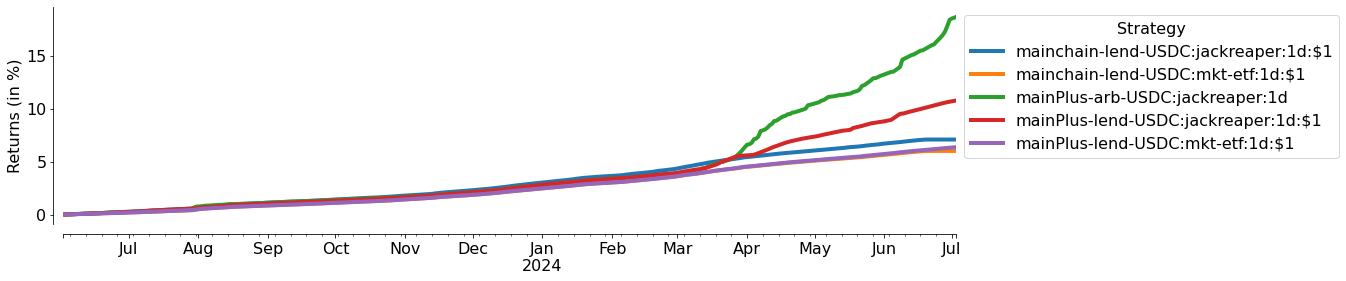

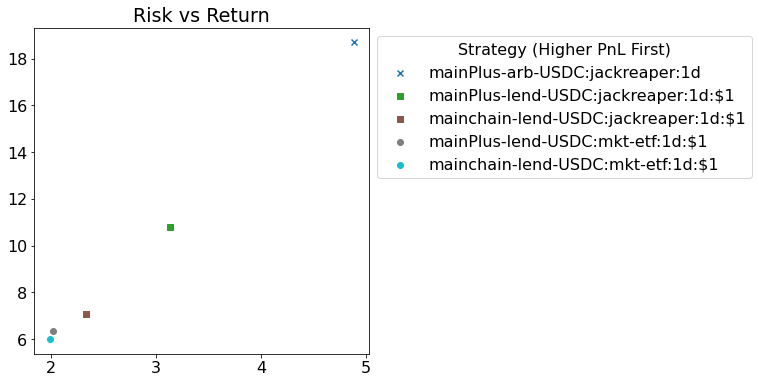

mainchain-lend-USDC:jackreaper:1d:$1     7.089111
mainchain-lend-USDC:mkt-etf:1d:$1        6.010555
mainPlus-arb-USDC:jackreaper:1d         18.688585
mainPlus-lend-USDC:jackreaper:1d:$1     10.782025
mainPlus-lend-USDC:mkt-etf:1d:$1         6.368559
dtype: float64


In [80]:
plot = Plotter(summary)
plot.summary_view()

# Running Backtests in Parallel

In [81]:
from dope.backengine.worker import BackgroundWorker

In [82]:
# logs
worker = BackgroundWorker(work_lim=4)

CAPstr = f"${CAPITAL/1_000_000:.2f}M"
strategy = LenderJackReaper(token=token, capital=CAPITAL, days_window=d, parts=20, triggers=TRIGGERS)
arbt = ArbBacktester(strategy=strategy, borrow_lend_data=run_data, data=run_data, mkt_impact=mkt_impact)
bt_string = token+f":jackreaper:{d}d:{CAPstr}"
worker.request_work(bt_string, arbt)

In [48]:
worker.active_work

<Synchronized wrapper for c_int(2)>

In [62]:
len(worker.get_queue_status())

0

In [61]:
worker.get_running_tasks()

{'USDC:jackreaper:1d:$0.60M': 'Process-13',
 'USDC:mkt-etf:1d:$0.60M': 'Process-15',
 'USDC:jackreaper:1d:$0.70M': 'Process-16',
 'USDC:mkt-etf:1d:$0.70M': 'Process-14'}